# Image Colorization with U-Net and GAN Tutorial

Credit: Moein Shariatnia from Towards Data Science
https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8

## 1 - Implementing the paper

### 1.1- Loading Image Paths

The study employs the entire ImageNet dataset, encompassing a massive 1.3 million images. However, for this project, I'm utilizing just 8,000 images from the COCO dataset, which were readily available on my device. Therefore, the size of our training set is just 0.6% of what the original paper used. Virtually any dataset with a diverse range of scenes and locations can be suitable for this task, as the goal is to train the model to colorize them effectively. For instance, ImageNet could be an option, but for this project, you would only need 8,000 of its images.

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import sys

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### 1.1.x Preparing Colab for running the code

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!sudo apt-get install python3.7
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1

!sudo apt install python3-pip
!sudo apt install python3.7-distutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support
  python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7
  python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minima

In [ ]:
!pip install fastai==2.4 --use-deprecated=legacy-resolver --root-user-action=ignore


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --root-user-action


The subsequent steps will download approximately 20,000 images from the COCO dataset. It's important to note that we'll only be using 8,000 of these images for training purposes. Additionally, other datasets such as ImageNet are also suitable for this project, provided they encompass a diverse range of scenes and locations.

In [ ]:
 from fastai.data.external import untar_data, URLs
 coco_path = untar_data(URLs.COCO_SAMPLE)
 coco_path = str(coco_path) + "/train_sample"
 use_colab = True

In [ ]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(42)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


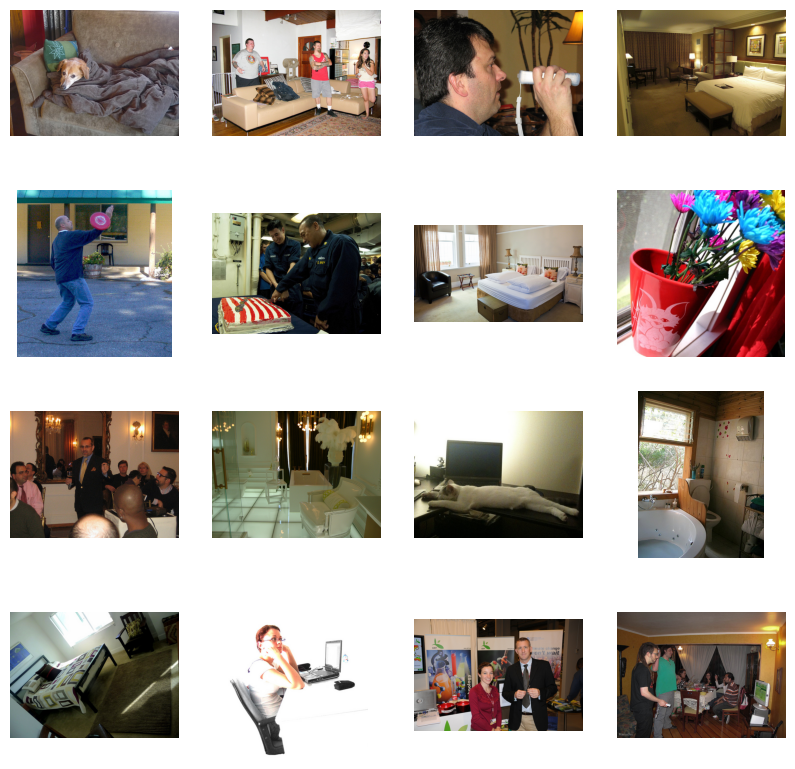

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

Even though we are utilizing the same dataset and the same quantity of training samples, the specific set of 8,000 images used to train your model might differ. This variation can occur despite using a seed, as the dataset in this instance comprises only 20,000 images with a different order, whereas I originally sampled 10,000 images from the entire dataset.

### 1.2- Making Datasets and DataLoaders

I resize the images and apply horizontal flipping (but only for the training set). Afterward, I load an RGB image, convert it to the Lab color space, and split it into two parts: the first channel (grayscale) serves as the input for the models, while the remaining color channels are used as targets. Following this, I proceed to create the data loaders.

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


### 1.3- Generator proposed by the paper

The code being discussed is designed to create a U-Net, which functions as the generator in a Generative Adversarial Network (GAN). While the specifics of the code are beyond the current discussion, it's essential to grasp that the construction of the U-Net starts from its central part, located at the bottom of the U shape. As the process progresses, down-sampling and up-sampling modules are systematically added to the left and right sides, respectively. This addition continues in each iteration, extending from the middle module outwards until the input and output modules are incorporated.

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

The structure of the discriminator in this context is relatively uncomplicated. The code constructs a model by sequentially layering units comprising Convolution (Conv), Batch Normalization (BatchNorm), and Leaky Rectified Linear Unit (LeakyReLU). These blocks work in tandem to evaluate if an input image is authentic or fabricated. It's important to note that the first and final blocks diverge from this pattern; the initial block does not incorporate normalization, and the final block lacks an activation function. Instead, the activation functionality for the last block is integrated into the loss function that will be utilized.

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Let's examine the components of its structure:

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

The model uses a "Patch" Discriminator, which differs from a standard discriminator. Instead of outputting a single value for the entire image, it evaluates individual 70x70 pixel patches of the image, determining the authenticity of each patch separately. This approach is more effective for tasks like colorization, where local details are crucial. The model's output shape is 30x30, but this does not mean the patches are 30x30 pixels. Instead, the actual patch size is 70x70 pixels, determined by the receptive field of each of the 900 (30 times 30) outputs. This method allows for a more nuanced assessment of the image's authenticity at a granular level.

### 1.5- GAN Loss

This class is a useful tool for computing the GAN loss of our ultimate model. Within the `__init__` method, we select the type of loss to utilize (which, for our project, will be "vanilla") and establish constant tensors to represent the "real" and "fake" labels. Upon invoking this module, it generates a tensor filled with either zeros or ones, based on the current requirement, and then proceeds to calculate the loss.

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article:

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class consolidates all the previously developed segments and introduces several methods for the effective training of our full model. Let's delve into its structure and functionality.

During the initialization phase (__init__), the generator and discriminator are established using the functions and classes defined earlier. They are also initialized through the `init_model` function, which is not elaborated here but can be understood in detail from my GitHub repository. Additionally, two loss functions and the optimizers for both the generator and discriminator are set up.

The principal operation occurs in the class's `optimize` method. Here, at each iteration (or batch of the training set), the module's forward method is called exactly once, and the results are stored in the `fake_color` variable of the class.

The training begins with the discriminator, using the `backward_D` method. In this step, fake images generated by the generator are fed to the discriminator (ensuring detachment from the generator's graph to act as constants) and labeled as fake. Subsequently, a batch of real images from the training set is fed to the discriminator and labeled as real. Both losses for fake and real images are combined, averaged, and then processed through the backward function to calculate the final loss.

Training the generator follows. In the `backward_G` method, the discriminator is presented with the fake image, attempting to deceive it by labeling these images as real to calculate the adversarial loss. Additionally, we employ L1 loss to measure the difference between the predicted and target channels, multiplied by a coefficient (100 in this case) to balance both losses. This total loss is then added to the adversarial loss, followed by calling the backward method on this cumulative loss.

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

The functions mentioned here were not covered in the TDS article's explanations. They serve as utility functions, primarily for recording the network's losses and for visualizing the results throughout the training process. You can explore these functions in detail here:

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

### 1.7- Training function

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

#model = MainModel()
#train_model(model, train_dl, 1)

## 2- A new strategy - the final model

The focus of this article is centered around a specific approach that was utilized to address a problem previously mentioned. Inspired by a concept from Super Resolution literature, the generator was pre-trained separately in a supervised and deterministic way. This method was chosen to avoid the issue known as "the blind leading the blind" in GAN training, where initially, neither the generator nor the discriminator possesses adequate knowledge about the task.

Pre-training was conducted in two stages:
1. **Backbone Pre-training:** The down-sampling path of the generator, initially, was pre-trained as a classification model using ImageNet.
2. **Full Generator Pre-training:** The entire generator was then pre-trained for the task of colorization, employing L1 loss.

A pre-trained ResNet18 model was used as the backbone of the U-Net. For the second stage of pre-training, the U-Net was trained on the training set exclusively with L1 Loss. Subsequently, training that combined both adversarial and L1 losses was undertaken, as previously described.

### 2.1- Using a new generator

The construction of a U-Net with a ResNet backbone is a non-trivial task. Therefore, the Dynamic U-Net module from the fastai library will be employed for its simplified assembly.

For the code provided to run without errors, fastai version 2.4 needs to be installed.

In [ ]:
#!pip install fastai==2.4

In [ ]:
#!pip --version

In [ ]:
#!pip3 list

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from fastai.vision import models
import torch
from fastai.vision.data import *

In [ ]:
#!pip3 install git+https://github.com/fastai/fastai.git

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(pretrained=True), cut=-2, n_in=n_input)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

Indeed, with just a few lines of code, one can easily construct a complex model. The `create_body` function is designed to load the pre-trained weights of the ResNet18 architecture and modify the model by removing the final two layers - specifically, the Global Average Pooling layer and a Linear layer, which are typically used for the ImageNet classification task. Following this, the `DynamicUnet` is utilized to construct a U-Net using this backbone. This U-Net is tailored to have the necessary output channels (two in this instance) and is configured for an input size of 256.

### 2.2 Pretraining the generator for colorization task

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 25) # epoch number
torch.save(net_G.state_dict(), "res18-unet2.pt")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/25
L1 Loss: 0.08663


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/25
L1 Loss: 0.08315


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/25
L1 Loss: 0.08253


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/25
L1 Loss: 0.08205


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/25
L1 Loss: 0.08167


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/25
L1 Loss: 0.08127


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/25
L1 Loss: 0.08091


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/25
L1 Loss: 0.08051


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/25
L1 Loss: 0.07998


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/25
L1 Loss: 0.07947


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/25
L1 Loss: 0.07872


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/25
L1 Loss: 0.07818


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/25
L1 Loss: 0.07712


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/25
L1 Loss: 0.07611


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/25
L1 Loss: 0.07551


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/25
L1 Loss: 0.07442


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/25
L1 Loss: 0.07347


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/25
L1 Loss: 0.07276


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/25
L1 Loss: 0.07177


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/25
L1 Loss: 0.07113


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21/25
L1 Loss: 0.07046


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22/25
L1 Loss: 0.06996


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 23/25
L1 Loss: 0.06930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24/25
L1 Loss: 0.06876


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 25/25
L1 Loss: 0.06825


This straightforward function enables the pretraining of the generator for 25 epochs, after which its weights are saved. This process is expected to take approximately an hour when using Colab. In the subsequent section, this pretrained model will be employed as the generator for our GAN, and the entire network will be trained as described previously:

### 2.3 Putting everything together, again!

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet2.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20) # epoch number

In this step, the saved weights for the generator, which were preserved in the previous section, are loaded. Subsequently, this model is incorporated as the generator within our MainModel class, effectively preventing it from undergoing random initialization. The training process for the model is then conducted over the course of 20 epochs. It's worth noting that each epoch requires approximately 3 to 4 minutes on Colab.

In [ ]:
# After training the model
torch.save(model.state_dict(), 'final_model_weights2.pt')


In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet2.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("final_model_weights2.pth", map_location=device))

model initialized with norm initialization


<All keys matched successfully>